In [1]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import matplotlib.image as mpimg
print(tf.__version__)
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import nashpy as nash
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L2
from time import sleep



2.3.0


In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0

test_images = test_images / 255.0

images = np.concatenate((train_images,test_images))
labels = np.concatenate((train_labels,test_labels))
#X = X[:500]
#Y = Y[:500]
#train_labels = to_categorical(train_labels)
idx = np.argsort(train_labels)

train_images_sorted = images[idx]
train_labels_sorted = labels[idx]



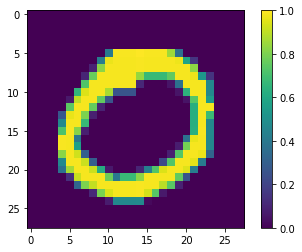

In [3]:
#x_train_zeros = train_images_sorted[train_labels == 0]

i = train_images_sorted[0]
plt.figure()
plt.imshow(i)
plt.colorbar()
plt.grid(False)
plt.show()


In [4]:
params = {
  "S1": [-0.1,-0.1,0,0],
  "S2": [-0.1,0,0,0.1],
  "S3": [-0.1,-0.1,0,0.1],
  "S4": [0,-0.1,0.1,0],
  "S5": [0,0,0.1,0.1],
  "S6": [0,-0.1,0.1,0.1],
  "S7": [-0.1,-0.1,0.1,0],
  "S8": [-0.1,0,0.1,0.1],
  "S9": [-0.1,-0.1,0.1,0.1]
}



def applyThreshold(a,b,Difference):

    filteredList = []
        
    for li in Difference:
        #print(li.shape)
        li = np.squeeze(li)
        #print(li.shape)
        #print("Squeezed",li)
        li = np.where(li <= a,li,1)
        #print("After alpha",li)
        li = np.where(li >= b,li,0)
        #print("after Beta",li)
        li = np.where(li != a,li,1)
        li = np.where(li != b,li,0) 
        filteredList.append(li)
    return filteredList
  

def countFreeze(filteredList):
    sum = 0
    for d in filteredList:
        sum += np.count_nonzero(d == 0)
    return sum

def countDuplicate(filteredList):
    sum = 0
    for d in filteredList:
        sum += np.count_nonzero(d == 1)
    return sum 

def countTotalNodes(filteredList):
    sum = 0
    for d in filteredList:
        sum += d.shape[0]
    return sum 
  

In [5]:
def apply_GTRS(Difference):
   
    iter = 0
    chk = False
    oldAlphaBeta = [[],[],[]]
    oldPlayersValues = [[],[],[]]
    
    X = []
    freeze = []
    retrain = []
    duplicate = [] 
     
    alpha = 1
    beta = 0

    oldR = oldC = 0
    r = c = 0
    while(True):
        #print("\n\nItreation Number: ",iter+1,"\n")  
        playersValues = [[],[],[]]
        newAlphaBeta = [[],[],[]]
        stab = [[],[],[]]
        plast = [[],[],[]]
        i = 0
        filteredList = applyThreshold(alpha,beta,Difference[:])
        numOfFreezeNodes = countFreeze(filteredList)
        #print("\nNumber of Freeze Nodes: ",numOfFreezeNodes)
        numOfDuplicateNodes = countDuplicate(filteredList)
        #print("\nNumber of Duplicate Nodes: ",numOfDuplicateNodes)
        totalNodes = countTotalNodes(filteredList)
        #print("\nNumber of total Nodes: ",totalNodes)
        numOfRetrainNodes = totalNodes - numOfFreezeNodes - numOfDuplicateNodes
        #print("\nNumber of Retrain Nodes: ",numOfRetrainNodes)
                 

        abstr = "alpha: "+str(round(alpha,2))+" beta: "+str(round(beta,2))

        X.append(abstr)

        freeze.append(numOfFreezeNodes)
        retrain.append(numOfRetrainNodes)
        duplicate.append(numOfDuplicateNodes)
        
       
        
        X_axis = np.arange(len(X))
        
        for key in params.keys():
        
            a = alpha + params[key][0]+ params[key][1]
            b = beta + params[key][2]+ params[key][3]
            
            
            newAlphaBeta[i//3].append(tuple([a,b]))
            #print("alpha for "+key+" :",a)
            #print("beta for "+key+" :",b)
            filteredList = applyThreshold(a,b,Difference[:])
            
            numOfFreezeNodes = countFreeze(filteredList[:])
            #print("\nNumber of Freeze Nodes: ",numOfFreezeNodes)
    
            numOfDuplicateNodes = countDuplicate(filteredList[:])
            #print("\nNumber of Duplicate Nodes: ",numOfDuplicateNodes)
    
            totalNodes = countTotalNodes(filteredList[:])
            #print("\nNumber of total Nodes: ",totalNodes)
            
            numOfRetrainNodes = totalNodes - numOfFreezeNodes - numOfDuplicateNodes
            #print("\nNumber of retrain Nodes: ",numOfRetrainNodes)
           
            stability = (numOfFreezeNodes + numOfDuplicateNodes)/totalNodes
            #print("Stability for "+key+" :",stability)
            plasticity = 1-stability
            #print("Plasticity for "+key+" :",plasticity)
            playersValues[i//3].append(tuple([plasticity,stability]))
            stab[i//3].append(stability)
            plast[i//3].append(plasticity)
            
            i += 1
    
        stab = np.array(stab)
        plast = np.array(plast)
        
        game = nash.Game(plast,stab)
    
        oldR = r
        oldC = c
        r = 0
        c = 0
        
        equilibria = game.support_enumeration()
        for eq in equilibria:
            r = eq[0].tolist().index(1.0)
            c = eq[1].tolist().index(1.0)


        hyperParameter = newAlphaBeta[r][c]
       
        if hyperParameter[0] <= 0.5 or hyperParameter[1] > 0.5:
            chk = True
            #print("\nalpha beta voilated")
            break
            
        
    
        alpha,beta = hyperParameter
        oldAlphaBeta = newAlphaBeta
    
        oldPlayersValues = playersValues
        
        
        #print("New optimum stability and plasticity: ",oldPlayersValues[r][c])
        #print("New optimum alpha and beta: ",oldAlphaBeta[r][c])
        #print(r,c)
    
        #print("new alpha betas :",alpha,beta)
        iter +=1 
 
    freeze = np.array(freeze)
    retrain = np.array(retrain)
    duplicate = np.array(duplicate)
    
    dd = np.array((freeze,retrain,duplicate))
    
    df = pd.DataFrame(dd,index = ["freeze","retrain","duplicate"],columns = X).T
    ax = df.plot.bar(width = 0.8)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.025))
    plt.ylabel("Number of nodes")
    plt.xlabel("Iterations")
    plt.title('Nodes Distribution')
    plt.show()
    #print("optimum stability and plasticity: ",oldPlayersValues[oldR][oldC])
    #print("optimum alpha and beta: ",oldAlphaBeta[oldR][oldC])
    #print(oldR,oldC)
    
    return oldAlphaBeta[oldR][oldC]#(oldAlphaBeta[oldR][oldC])

In [17]:
def normalize_weights(weights):
    for i in range(1,len(weights),2):
        weights[i] = np.expand_dims(weights[i], axis=1)
    
    scaler = MinMaxScaler()

    for i in range(len(weights)):
        scaler.fit(weights[i])
        weights[i] = scaler.transform(weights[i])
    
    return weights 


def train_model(model,X_train, y_train):
    #print(model.summary())  
    start = time()
    model.fit(X_train, y_train, epochs=3)
    Time = time()-start
    print("Training Time in Secs: ",Time)
    return Time    
    
    
    #return (Time,test_loss,test_acc)



def avg_and_normalize_differences(Difference):
    for i in range(0,len(Difference),2):
        Difference[i] = np.average(Difference[i],axis = 0)

        
    for i in range(0,len(Difference),2):
        Difference[i] = np.expand_dims(Difference[i], axis=1)
        
    newDifference = []
    for i in range(0,len(Difference),2):
        newDifference.append(np.average(Difference[i:i+2]))
    
    scaler = MinMaxScaler()
    for i in range(len(newDifference)):
        scaler.fit(newDifference[i])
        newDifference[i] = scaler.transform(newDifference[i])
    
    return newDifference


def update_model(layers_shape,newWeights):

    H1 = tf.keras.layers.Dense(units =layers_shape[0][0], activation= "relu")#  kernel_regularizer=tf.keras.regularizers.L2(0.1) 
    H2 = tf.keras.layers.Dense(units =layers_shape[1][0], activation= "relu")
    H3 = tf.keras.layers.Dense(units =layers_shape[2][0], activation= "relu")#kernel_regularizer=tf.keras.regularizers.L2(0.01),bias_regularizer=tf.keras.regularizers.L2(0.01)
    out = tf.keras.layers.Dense(units =2, activation= "sigmoid")


    #out = SimpleDense(units = 2, activation="sigmoid")#layers_shape[3][1]


    newModel = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)),
        tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
        #tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        #tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
      
        tf.keras.layers.Flatten(),
        H1,
        H2,
        H3,
        out
    
    ])
    
    opt =tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
    
    
    newModel.compile(optimizer=opt,
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
    newModel.build((None,28,28))
    newModel.set_weights(newWeights)
    return newModel
        
def duplicate_neuron(filteredList,mainWeights,model):
    k = 0
    z = 4#6
    layers_shape = []
    for i in range(3):#[7:-1]
        #print("Shape before duplication: ",mainWeights[z][0].shape)
        m = np.nonzero(filteredList[k] == 1)
    
        dplW = []
        dplB = []
        dplWN = []
        
        
        for j in m[0]:
            #print(j)
            #print(mainWeights[z].shape)
            dplW.append(mainWeights[z][:,j])
            dplB.append(mainWeights[z+1][j])
            dplWN.append(mainWeights[z+2][j])
        
            
        dplW = np.array(dplW)
        dplW = dplW.T
        dplB = np.array(dplB)
        #print(dplB.shape)
        if(len(dplB.shape) == 2):
            dplB = np.squeeze(dplB)
        
        dplWN = np.array(dplWN)
        
        #print(dplB.shape)
        #print(mainWeights.shape)
        
        if(dplW.shape[0] != 0):
            mainWeights[z] = np.concatenate((mainWeights[z],dplW),1)
            mainWeights[z+2] = np.insert(mainWeights[z+2], 1,dplWN, axis=0)
        layers_shape.append(mainWeights[z][0].shape)
       
        if(dplW.shape[0] != 0):
            mainWeights[z+1] = np.concatenate((mainWeights[z+1],dplB),0)
            
        #print("Shape after duplication: ",mainWeights[z][0].shape)

        k +=1
        z +=2
    layers_shape.append(model.layers[-1].weights[0].shape)
    #update_model(layers_shape,mainWeights)
    return (layers_shape,mainWeights)

def freeze_neurons(filteredList,model,mainWeights,updatedWeights):
    k = 0
    z = 4#6
    for i in range(3):#[7:-1]
        m = np.nonzero(filteredList[k] == 0)
        #print("printing layer")
        #print(i)
        for j in m[0]:
            #print(j)
            #print(updatedWeights[z].shape)
            #print(mainWeights[z].shape)
            updatedWeights[z][:,j] = mainWeights[z][:,j]
            updatedWeights[z+1][j] = mainWeights[z+1][j]
        m = np.nonzero(filteredList[k] == 1)
        for j in m[0]:
            #print(j)
            #print(updatedWeights[z].shape)
            #print(mainWeights[z].shape)
            updatedWeights[z][:,j] = mainWeights[z][:,j]
            updatedWeights[z+1][j] = mainWeights[z+1][j]
        k +=1
        z +=2

    model.set_weights(updatedWeights)
    
    #Duplicate, freeze,total
def get_time(time,paras):  
    total = paras[0]+paras[2]
    per = time / total
    time = time - (per*paras[1])
    return time   

def selectiveTesting(m,currM):
    for i in range(4,10,2):
        size = m[i].shape
        #print("Before")
        #print(currM[i][:,size[1]:]) 
        currM[i][:,size[1]:].fill(0)
        #print("after")
        #print(currM[i][:,size[1]:])
        #print("Before")
        #print(currM[i+1][size[1]:])
        currM[i+1][size[1]:].fill(0)
        #print("after")
        #print(currM[i+1][size[1]:])
    #a = currM[-2].shape[0]
    #b = m[-2].shape[0]
    #currM[-2][:b] = m[-2]
    #currM[-2][b:] = 0
    #print(currM[-2][:])
    #print(m[-2])
    #print(m[-2].shape)
    
    return currM

In [18]:
H1 = tf.keras.layers.Dense(units =784, activation= "relu")    
H2 = tf.keras.layers.Dense(units =200, activation= "relu")
H3 = tf.keras.layers.Dense(units =40, activation= "relu")
out = tf.keras.layers.Dense(units =2, activation= "sigmoid")


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)),
    tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
    #tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    #tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
    
    tf.keras.layers.Flatten(),
    H1,
    H2,
    H3,
    out
])

opt =tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
model.compile(optimizer=opt,
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])



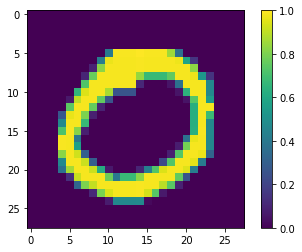

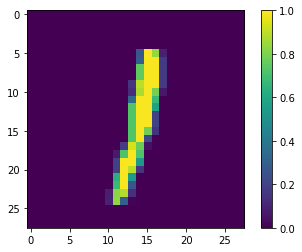

Epoch 1/3
278/278 [==============================] - 7s 24ms/step - loss: 0.0281 - accuracy: 0.9936
Epoch 2/3
278/278 [==============================] - 7s 24ms/step - loss: 0.0026 - accuracy: 0.9991
Epoch 3/3
278/278 [==============================] - 6s 23ms/step - loss: 0.0032 - accuracy: 0.9993
Training Time in Secs:  20.193652391433716
119/119 - 1s - loss: 0.0021 - accuracy: 0.9997
confusion matrix
[[1805    0]
 [   1 1994]]
AUC:  0.9997493734335839

Test acc: 0.9997368454933167


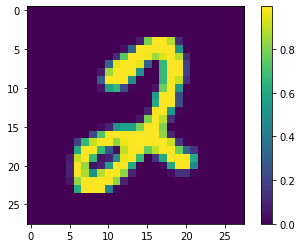

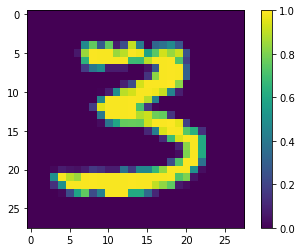

Epoch 1/3
82/82 [==============================] - 2s 21ms/step - loss: 0.2076 - accuracy: 0.9381
Epoch 2/3
82/82 [==============================] - 2s 20ms/step - loss: 0.0339 - accuracy: 0.9865
Epoch 3/3
82/82 [==============================] - 2s 20ms/step - loss: 0.0167 - accuracy: 0.9938
Training Time in Secs:  5.140146732330322


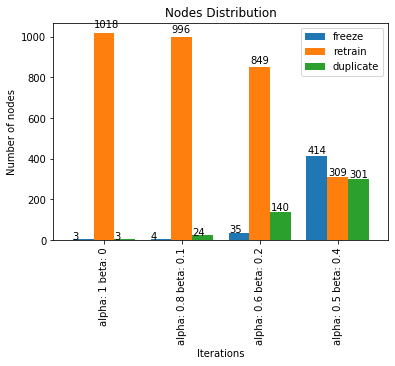

Epoch 1/3
542/542 [==============================] - 13s 23ms/step - loss: 0.0418 - accuracy: 0.9836
Epoch 2/3
542/542 [==============================] - 13s 24ms/step - loss: 0.0148 - accuracy: 0.9949
Epoch 3/3
542/542 [==============================] - 13s 24ms/step - loss: 0.0082 - accuracy: 0.9970
Training Time in Secs:  38.624834299087524
233/233 - 1s - loss: 0.1119 - accuracy: 0.9806
confusion matrix
[[3408  139]
 [   5 3875]]
AUC:  0.9797616469849648

Test acc: 0.980611264705658
0
Test accuracy on number of tasks : 1
119/119 - 1s - loss: 0.5004 - accuracy: 0.9963
Test acc:   0.9963157773017883
confusion matrix
[[1792   13]
 [   1 1994]]
AUC:  0.996148265400343


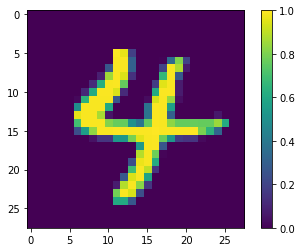

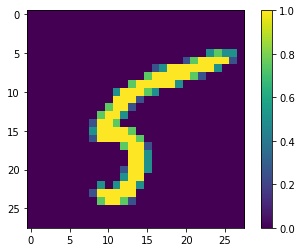

Epoch 1/3
81/81 [==============================] - 2s 23ms/step - loss: 0.0592 - accuracy: 0.9795
Epoch 2/3
81/81 [==============================] - 2s 23ms/step - loss: 0.0137 - accuracy: 0.9965
Epoch 3/3
81/81 [==============================] - 2s 24ms/step - loss: 0.0057 - accuracy: 0.9969
Training Time in Secs:  5.824082612991333


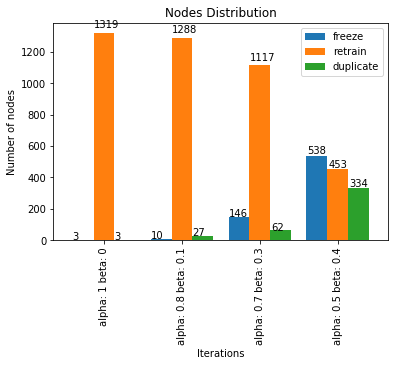

Epoch 1/3
540/540 [==============================] - 14s 26ms/step - loss: 0.0261 - accuracy: 0.9902
Epoch 2/3
540/540 [==============================] - 14s 26ms/step - loss: 0.0108 - accuracy: 0.9972
Epoch 3/3
540/540 [==============================] - 16s 31ms/step - loss: 0.0086 - accuracy: 0.9977
Training Time in Secs:  45.3125364780426
232/232 - 1s - loss: 0.1798 - accuracy: 0.9832
confusion matrix
[[3610    4]
 [ 120 3667]]
AUC:  0.9836029208361287

Test acc: 0.9832454919815063
0
Test accuracy on number of tasks : 1
119/119 - 1s - loss: 0.4956 - accuracy: 0.9811
Test acc:   0.9810526371002197
confusion matrix
[[1805    0]
 [  72 1923]]
AUC:  0.9819548872180451
1
Test accuracy on number of tasks : 2
233/233 - 1s - loss: 0.4851 - accuracy: 0.9760
Test acc:   0.9760333895683289
confusion matrix
[[3506   41]
 [ 137 3743]]
AUC:  0.9765658288258702


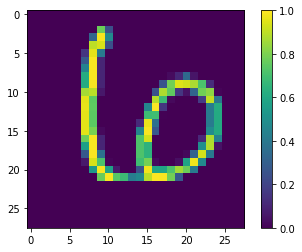

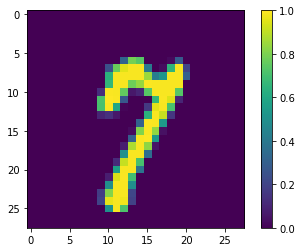

Epoch 1/3
87/87 [==============================] - 2s 27ms/step - loss: 0.3850 - accuracy: 0.8593
Epoch 2/3
87/87 [==============================] - 3s 35ms/step - loss: 0.3433 - accuracy: 0.9613
Epoch 3/3
87/87 [==============================] - 3s 29ms/step - loss: 0.3390 - accuracy: 0.9584
Training Time in Secs:  8.269674062728882


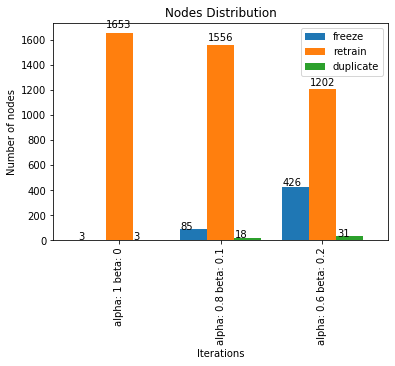

Epoch 1/3
576/576 [==============================] - 17s 29ms/step - loss: 0.0292 - accuracy: 0.9912
Epoch 2/3
576/576 [==============================] - 17s 29ms/step - loss: 0.0106 - accuracy: 0.9971
Epoch 3/3
576/576 [==============================] - 17s 30ms/step - loss: 0.0077 - accuracy: 0.9979
Training Time in Secs:  51.480929136276245
247/247 - 2s - loss: 0.0101 - accuracy: 0.9978
confusion matrix
[[3732    7]
 [  10 4150]]
AUC:  0.9978619977575246

Test acc: 0.997847855091095
0
Test accuracy on number of tasks : 1
119/119 - 1s - loss: 0.4297 - accuracy: 0.9989
Test acc:   0.9989473819732666
confusion matrix
[[1801    4]
 [   0 1995]]
AUC:  0.9988919667590027
1
Test accuracy on number of tasks : 2
233/233 - 2s - loss: 0.3370 - accuracy: 0.9871
Test acc:   0.9870741963386536
confusion matrix
[[3456   91]
 [   5 3875]]
AUC:  0.9865279283494982
2
Test accuracy on number of tasks : 3
232/232 - 2s - loss: 0.0461 - accuracy: 0.9903
Test acc:   0.9902715682983398
confusion matrix
[[3

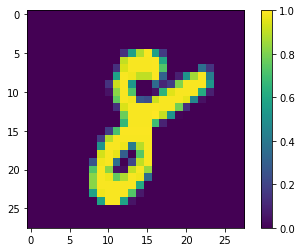

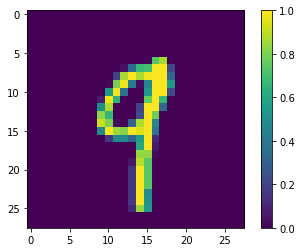

Epoch 1/3
88/88 [==============================] - 3s 31ms/step - loss: 0.0972 - accuracy: 0.9690
Epoch 2/3
88/88 [==============================] - 3s 30ms/step - loss: 0.0236 - accuracy: 0.9939
Epoch 3/3
88/88 [==============================] - 3s 30ms/step - loss: 0.0081 - accuracy: 0.9968
Training Time in Secs:  8.196072101593018


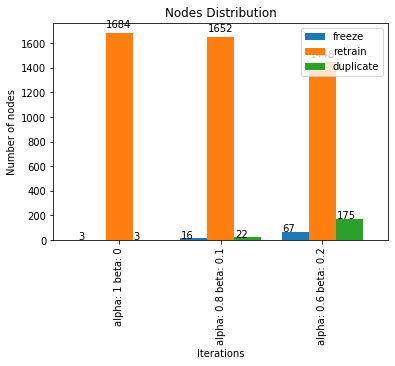

Epoch 1/3
585/585 [==============================] - 19s 32ms/step - loss: 0.0492 - accuracy: 0.9815
Epoch 2/3
585/585 [==============================] - 18s 31ms/step - loss: 0.0192 - accuracy: 0.9941
Epoch 3/3
585/585 [==============================] - 18s 31ms/step - loss: 0.0110 - accuracy: 0.9960
Training Time in Secs:  55.52881908416748
251/251 - 2s - loss: 0.0167 - accuracy: 0.9953
confusion matrix
[[3820   20]
 [  18 4163]]
AUC:  0.9952432382603842

Test acc: 0.9952624440193176
0
Test accuracy on number of tasks : 1
119/119 - 1s - loss: 0.4475 - accuracy: 0.9982
Test acc:   0.9981579184532166
confusion matrix
[[1801    4]
 [   3 1992]]
AUC:  0.9981400870597547
1
Test accuracy on number of tasks : 2
233/233 - 2s - loss: 0.2166 - accuracy: 0.9907
Test acc:   0.9907096028327942
confusion matrix
[[3534   13]
 [  56 3824]]
AUC:  0.9909509706184114
2
Test accuracy on number of tasks : 3
232/232 - 2s - loss: 0.0746 - accuracy: 0.9809
Test acc:   0.9809485077857971
confusion matrix
[[3

In [19]:
testingDataX = []
testingDataY = []
outPutLayer = []
trainingTime = []
accuracyMatrix = np.zeros((5,5))
aucRoc = np.zeros((5,5))
nodes_info = np.zeros((5,2))
nodes_info[0][1] = 1224
myModels = []


count = 0
start = time()
for i in range(0,10,2):    
    
    X = train_images_sorted[train_labels_sorted == i]
    #Y = train_labels_sorted[train_labels_sorted == i]
    Y = np.zeros(X.shape[0])
    

    X2 = train_images_sorted[train_labels_sorted == i+1]
    #Y2 = train_labels_sorted[train_labels_sorted == i+1]
    
        
    X = np.concatenate((X,X2))
    #Y = np.concatenate((Y,Y2))
    Y = np.concatenate((Y,np.ones(X2.shape[0])))
    
    x_ = X
    y_ = Y
    
        
    plt.figure()
    plt.imshow(X[0])
    plt.colorbar()
    plt.grid(False)
    plt.show()

    
    #print(Y[:10])
    
    plt.figure()
    plt.imshow(X[-1])
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
    #print(Y[-10:])
    if i != 0:
        
        X = np.concatenate((X,sampleX))
        Y = np.concatenate((Y,sampleY))
        
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    #X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.60, random_state=42)
    
    X_train = tf.expand_dims(X_train,-1)
    X_test = tf.expand_dims(X_test,-1)
    #X_val = tf.expand_dims(X_val,-1)
    testingDataX.append(X_test)
    testingDataY.append(y_test)
    #print("testingDataX size: ",len(testingDataX))
    #print("testingDataY size: ",len(testingDataY))
    
    if count > 0:
        
        mainWeights = model.get_weights()
        
        #previous_weights = normalize_weights(mainWeights[4:-2])#4
        previous_weights = mainWeights[4:-2]#[6:-2]
        for x in range(1,len(previous_weights),2):
            previous_weights[x] = np.expand_dims(previous_weights[x], axis=1)  
            
        split = X_train.shape[0]*15//100
        train_model(model,X_train[:split], y_train[:split])
        
        
        current_weights = model.get_weights()
        #current_weights = normalize_weights(current_weights[4:-2])#4
        current_weights = current_weights[4:-2]#[6:-2]
        
        
            
        for x in range(1,len(current_weights),2):
            current_weights[x] = np.expand_dims(current_weights[x], axis=1)    
        
            
        
        Difference = np.subtract(current_weights,previous_weights)
        Difference = avg_and_normalize_differences(Difference)
        
        #for i in range(len(Difference)):
            #Difference[i] = Difference[i] - 0.2
  
        parameters = apply_GTRS(Difference)
        #print("alpha:",parameters[0])
        #print("beta:",parameters[1])
        
        filteredList = applyThreshold(parameters[0],parameters[1],Difference)      
        #filteredList = applyThreshold(0.4,0.6,Difference)
        
        nodes_info[count][0] = countDuplicate(filteredList) 
        nodes_info[count][1] = countTotalNodes(filteredList)
        f = countFreeze(filteredList)
        
        model.set_weights(mainWeights)
    
        if(type(mainWeights) ==  list):
            mainWeights =np.array(mainWeights)
    
        model_info = duplicate_neuron(filteredList[:],mainWeights,model)
        
        
        model = update_model(model_info[0],model_info[1])
        
        mainWeights = model.get_weights()
        
        outPutLayer.append(model.layers[-1].weights)
       
    
    Time = train_model(model,X_train, y_train)
    
    
    if(count == 0):
        trainingTime.append(Time)
    else:
        trainingTime.append(get_time(Time,(nodes_info[count][0],f,nodes_info[count][1])))
    
    
    if(count > 0):
        freeze_neurons(filteredList[:],model,mainWeights,model.get_weights())
        
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    
    predictions = model.predict_classes(X_test)
    #print(y_test[0])
    #print(predictions[0])
    c_matrix = confusion_matrix(y_test,predictions)
    print("confusion matrix")
    print(c_matrix)
    
    
    #predictions = to_categorical(model.predict_classes(X_test))
    #print(predictions.shape)
    #print(y_test.shape)
    
    auc = roc_auc_score(y_test,predictions)
    
    print("AUC: ",auc)
    accuracyMatrix[count][count] = test_acc
    aucRoc[count][count] = auc
    print('\nTest acc:', test_acc)
 
    myModels.append(model)
    
    if(count > 0):
        weights = model.get_weights()
        for j in range(len(testingDataX)-1):
            print(j)
            print("Test accuracy on number of tasks : "+str(j+1))
            
            #weights[-1] = outPutLayer[j][-1].numpy()
            #weights[-2] = outPutLayer[j][-2].numpy()
            #model.set_weights(weights)
            testModel = myModels[j]
    
            uw =  selectiveTesting(testModel.get_weights(),model.get_weights())
            model.set_weights(uw)
            test_loss, test_acc = model.evaluate(testingDataX[j], testingDataY[j], verbose=2)
            accuracyMatrix[j][count] = test_acc
            
            print("Test acc:  ",test_acc)
            predictions = model.predict_classes(testingDataX[j])
            #print(valDataY[0])
            #print(predictions[0])
            c_matrix = confusion_matrix(testingDataY[j],predictions)
            print("confusion matrix")
            print(c_matrix)
            
            #predictions = to_categorical(model.predict_classes(testingDataY[j]))
            #print(predictions.shape)
            #print(valDataY.shape)
        
            auc = roc_auc_score(testingDataY[j],predictions)
            aucRoc[j][count] = auc
            print("AUC: ",auc)
            model.set_weights(weights)
            
    count = count + 1
    if i == 0:
        sampleX = x_
        sampleY = y_
    else:
        x_, y_ = shuffle(x_, y_, random_state=0)
        split = X.shape[0]*5//100
        sampleX = np.concatenate((sampleX,x_[:split]))
        sampleY = np.concatenate((sampleY,y_[:split]))
        
endTime = time() - start


In [105]:
#aucRoc

In [21]:
avgRoc = []
for i in range(5):
    t = aucRoc[:,i] 
    avg = np.average(t[np.nonzero(t)])
    avgRoc.append(avg)
    print("Average AUC-ROC after training "+str(i+1)+" tasks: ", avg)
avgRoc  = np.around(np.array(avgRoc),2)

Average AUC-ROC after training 1 tasks:  0.9997493734335839
Average AUC-ROC after training 2 tasks:  0.9879549561926539
Average AUC-ROC after training 3 tasks:  0.9807078789600147
Average AUC-ROC after training 4 tasks:  0.9933601788532279
Average AUC-ROC after training 5 tasks:  0.9917545860816555


In [22]:
avgRoc

array([1.  , 0.99, 0.98, 0.99, 0.99])

In [23]:
accuracyMatrix

array([[0.99973685, 0.99631578, 0.98105264, 0.99894738, 0.99815792],
       [0.        , 0.98061126, 0.97603339, 0.9870742 , 0.9907096 ],
       [0.        , 0.        , 0.98324549, 0.99027157, 0.98094851],
       [0.        , 0.        , 0.        , 0.99784786, 0.99354351],
       [0.        , 0.        , 0.        , 0.        , 0.99526244]])

In [24]:
avgAcc = []
for i in range(5):
    t = accuracyMatrix[:,i] 
    avg = np.average(t[np.nonzero(t)])
    avgAcc.append(avg)
    print("Average accuracy after training "+str(i+1)+" tasks: ", avg)
avgAcc = np.around(np.array(avgAcc),2)

Average accuracy after training 1 tasks:  0.9997368454933167
Average accuracy after training 2 tasks:  0.9884635210037231
Average accuracy after training 3 tasks:  0.9801105062166849
Average accuracy after training 4 tasks:  0.9935352504253387
Average accuracy after training 5 tasks:  0.9917243957519531


In [25]:
avgAcc

array([1.  , 0.99, 0.98, 0.99, 0.99])

In [54]:
trainingTime = list(np.around(np.array(trainingTime),2))
trainingTime

[53.53, 38.5, 30.62, 26.56, 20.19]

In [52]:
print("Total Learning Time:",sum(trainingTime))

Total Learning Time: 169.4


In [27]:
accuracyMatrix *= 100
avgAcc *= 100
aucRoc *= 100
avgRoc *= 100

Text(0.5, 1.0, 'AUC-ROC after N Tasks')

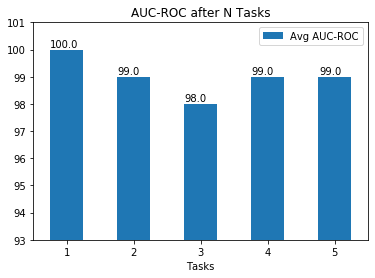

In [28]:
df1 = pd.DataFrame({'Tasks':['1', '2', '3', '4', '5'], 'Avg AUC-ROC':avgRoc})
ax1 = df1.plot.bar(x='Tasks', y='Avg AUC-ROC', rot=0)
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.001))
plt.ylim(93,101)
plt.title('AUC-ROC after N Tasks')

Text(0.5, 1.0, 'Average test accuracy after N tasks')

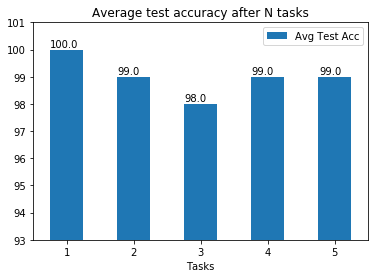

In [29]:
df2 = pd.DataFrame({'Tasks':['1', '2', '3', '4', '5'], 'Avg Test Acc':avgAcc})
ax2 = df2.plot.bar(x='Tasks', y='Avg Test Acc', rot=0)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.001))
plt.ylim(93,101)
plt.title('Average test accuracy after N tasks')

Text(0.5, 1.0, 'Training time for task T')

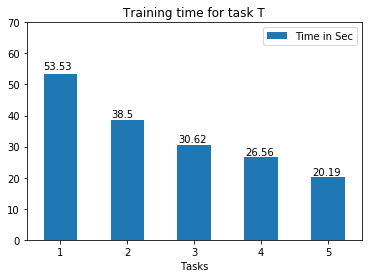

In [55]:
df3 = pd.DataFrame({'Tasks':['1', '2', '3', '4', '5'], 'Time in Sec':trainingTime})
ax3 = df3.plot.bar(x='Tasks', y='Time in Sec', rot=0)
for p in ax3.patches:
    ax3.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.025))
plt.ylim(0,70)
plt.title('Training time for task T')

In [1]:
#nodes_info

In [35]:
capacity = np.around(nodes_info[:,0]/nodes_info[:,1]*100,2)

In [36]:
capacity = capacity[1:]

Text(0.5, 1.0, '% of increased model capacity ')

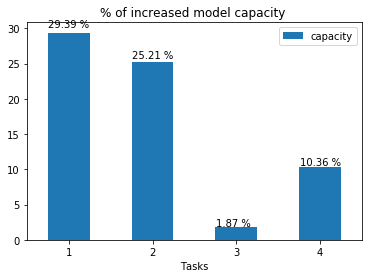

In [37]:
df4 = pd.DataFrame({'Tasks':['1', '2', '3', '4'], 'capacity':capacity})
ax4 = df4.plot.bar(x='Tasks', y='capacity', rot=0)
for p in ax4.patches:
    ax4.annotate(str(p.get_height())+" %", (p.get_x() * 1.005, p.get_height() * 1.025))
#plt.ylim(30,90)
plt.title('% of increased model capacity ')

In [49]:
layers_size = np.array([1124,595,146,2])

In [56]:
from numpy import savetxt
savetxt("./trainingResults/mnist/accMatrix_mnist.csv",accuracyMatrix,delimiter = ",")
savetxt("./trainingResults/mnist/aucRoc_mnist.csv",aucRoc,delimiter = ",")
savetxt("./trainingResults/mnist/avg_acc_mnist.csv",avgAcc,delimiter = ",")
savetxt("./trainingResults/mnist/avg_aucRoc_mnist.csv",avgRoc,delimiter = ",")
savetxt("./trainingResults/mnist/trainTime_mnist.csv",trainingTime,delimiter = ",")
savetxt("./trainingResults/mnist/nodes_info.csv",nodes_info,delimiter = ",")#layers_size
savetxt("./trainingResults/mnist/layers_size.csv",layers_size,delimiter = ",")
#savetxt("./trainingResults/mnistClassWise/accMatrixIL_mnist.csv",accuracyMatrixIL,delimiter = ",")

#savetxt("./trainingResults/mnistClassWise/isolatedTrainingTime_mnist.csv",isolatedTrainingTime,delimiter = ",")

#savetxt("./trainingResults/mnistClassWise/aucRocIL_mnist.csv",aucRocIL,delimiter = ",")

In [ ]:

    if i == 0:
        sampleX = x_
        sampleY = y_
    else:
        x_, y_ = shuffle(x_, y_, random_state=0)
        split = X.shape[0]*3//100
        sampleX = np.concatenate((sampleX,x_[:split]))
        sampleY = np.concatenate((sampleY,y_[:split]))
    